# Introduction

### Overview
I participated in the IMA-MathCEP Math Modeling Camp at the University of Minnesota in July 2024, engaging in a team-based project focused on mathematical modeling. The project addressed California’s 2035 mandate requiring all new vehicle purchases to be battery, plug-in hybrid, or fuel-cell electric vehicles, which increases electricity demand. My team analyzed how to meet this demand using renewable energy while keeping electricity costs low. The objectives included modeling greenhouse gas (GHG) emissions from vehicles, predicting energy grid changes, and optimizing the grid to meet California’s renewable energy targets.


## Background
California regulators recently adopted rules that would require all new purchases of cars and light trucks (starting in 2035) to include only battery, plug-in, or fuel-cell electric vehicles. This will reduce tailpipe emissions from vehicles, but will greatly increase the demand on the electric grid.

## Problem
You have been hired as a consultant by the state of California to suggest how they might meet this new electric demand in an environmentally responsible way. However, since the new vehicles will be more expensive, there is political pressure to ensure that the cost per kilowatt-hour (cost/kW) of electricity is low. Create a model that shows how quickly green house gas emission will decrease, and justify your choice of new energy production.

## Objectives
1. Develop a model to predict the reduction in greenhouse gas (GHG) emissions from vehicles as California transitions to electric vehicles by 2035.
2. Forecast the evolution of California’s energy grid to meet increasing electricity demand, aligning with the state’s renewable energy goals (52% by 2022, 60% by 2030, 90% by 2040, and 100% by 2045).
3. Optimize the energy grid to minimize the cost per kilowatt-hour while maximizing renewable energy sources, using a genetic algorithm to balance cost and environmental impact.

# Objective 1: Carbon Dioxide Emissions from Vehicles

## Objective Statement
Create a model to accurately predict the greenhouse gas (GHG) emissions from vehicles as the regulations take effect. This will be done in 2 steps: Create a function for GHG emissions from vehicles and derive the necessary parameter for the function

## Assumptions
- Carbon dioxide is the only GHG considered
- All cars that are registered are active
- The number of cars manufactured is equivalent to the number of cars sold

## Modeling
We will divide the function into two pieces: Before 2035 and after 2035. Before 2035, teh function considers carbon dioxide emitted from manufacturing cars and operating gasoline cars. After 2035, the function only considers carbon dioxide emitted from manufacturing cars. With mathematical intuition and public data available throught the State of California, my team was able to deduce the following function below.

$$\begin{equation*}
\mathrm{CO}_2
\mathrm{ \ emissions \ from \ vehicles}=
\begin{cases}
    \mathrm{CO}_2 \ \mathrm{from \ gas \ car \ tailpipes} + \mathrm{CO}_2 \ \mathrm{from \ gas \ car \ manufacture} + \mathrm{CO}_2 \ \mathrm{from \ EV \ manufacture} & \mathrm{} \ 2021 \leq t \leq 2035 \\
    \mathrm{CO}_2 \ \mathrm{from \ gas \ car \ manufacture} + \mathrm{CO}_2 \ \mathrm{from \ EV \ manufacture} & \mathrm{} \ 2035 < t \leq 2050
\end{cases}
\end{equation*}$$

### $\mathrm{CO}_2\$ from car tailpipes
$$=\mathrm{CO}_2 \ \mathrm{gas \ car \ emimssions \ per \ year} \cdot \mathrm{Gas \ car \ registration \ percentage} \cdot \mathrm{Annual \ number \ of \ car \ registrations}$$

$$
= \frac{
4.6 \times
\left\{
\begin{array}{ll}
\displaystyle \frac{9600e^{-0.123(t - 2016)}}{4 + 96e^{-0.123(t - 2016)}} & \text{for } 2021 \leq t < 2035 \\[10pt]
224.3e^{-0.0833(t - 2021)} & \text{for } t \geq 2035
\end{array}
\right.
\times \left[0.846(t - 2021) + 35 \cdot 10^6 \right]
}{100}
$$

### $\mathrm{CO}_2 \$ from gas car manufacture
$$=\mathrm{number \ of \ total \ cars \ sold} \cdot\mathrm{\% \ of \ gas \ car \ sold}\cdot\mathrm{6 \ metric \ tons}$$

$$=[0.041(t-2021) + 1,860,000]\times\frac{99.7 - 7.3(t-2021)}{100}\times6$$

### $\mathrm{CO}_2\$ from EV manufacture
$$=\mathrm{number \ of \ total \ cars \ sold}\cdot\mathrm{\% \ of \ electric \ cars \ sold}\cdot10\mathrm{\ metric \ tons}$$

$$=[0.041(t-2021) + 1,860,000]\times\frac{0.3 + 7.3(t-2021)}{100}\times10$$

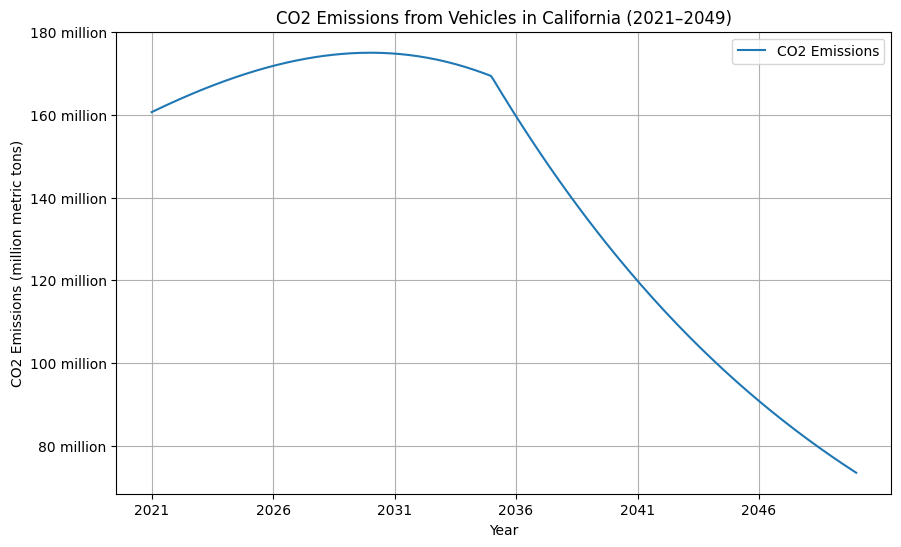

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the CO2 emissions function from vehicles
def co2_emissions(t):
    """
    Calculate CO2 emissions from vehicles based on California's regulatory timeline.

    Parameters:
    - t: Time in years since 2021 (e.g., t=0 means year 2021)

    Returns:
    - Total CO2 emissions in metric tons
    """

    # Tailpipe emissions are only considered before 2035
    if t < 14:  # Before 2035 (2021 + 14)
        # Annual number of car registrations (linear growth model)
        total_cars = 0.04 * t + 1.86e6

        # Gas car registration percentage (linear decrease from 99.7% to ~0.3%)
        gas_percentage = (99.7 - 7.3 * t) / 100

        # EV registration percentage (linear increase from 0.3% to ~99.7%)
        ev_percentage = (0.3 + 7.3 * t) / 100

        # Gas car tailpipe emissions (nonlinear decay model, based on policy impact)
        tailpipe_emissions_factor = (4.6 * 9600 * np.exp(-0.123 * (t + 5))) / (4 + 96 * np.exp(-0.123 * (t + 5)))

        # Registered gas vehicles (starting at 35 million, increasing over time)
        gas_vehicle_count = 35e6 + 846000 * t

        # CO2 from tailpipes
        term1 = (gas_vehicle_count * tailpipe_emissions_factor) / 100

        # CO2 from manufacturing gas cars
        term2 = total_cars * gas_percentage * 6

        # CO2 from manufacturing EVs
        term3 = total_cars * ev_percentage * 10

        return term1 + term2 + term3

    else:  # After 2035: only manufacturing emissions considered
        # Annual number of car registrations
        total_cars = 0.04 * t + 1.86e6

        # Gas car manufacture emissions decay with time (due to regulatory phase-out)
        gas_car_emissions = ((35e6 + 846000 * t) * (224.33 * np.exp(-0.0833 * t)) * 4.6) / 100

        # All new car sales assumed to be EVs after 2035
        ev_manufacture_emissions = total_cars * 10

        return gas_car_emissions + ev_manufacture_emissions


# Set up time range: 2021 (t=0) to 2049 (t=29)
years_start = 2021
t_values = np.linspace(0, 29, 300)  # 300 points for smooth plotting

# Evaluate CO2 emissions over the time range
emissions = np.array([co2_emissions(t) for t in t_values])

# Plotting the CO2 emissions
plt.figure(figsize=(10, 6))
plt.plot(t_values + years_start, emissions, label='CO2 Emissions')

# Labeling and styling
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('CO2 Emissions from Vehicles in California (2021–2049)')
plt.xticks(np.arange(years_start, years_start + 30, step=5))
plt.grid(True)
plt.legend()

# Format y-axis: display values in millions (e.g., "200 million")
formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f} million'.format(x / 1e6))
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()

# Objective 2: Energy Grid Prediction

## Objective Statement
Predict how the percentages of various energy sources responsible for energy production in the elctric grid change over time.

## California's Goal's for the Energy Grid
- 2022: 52% Renewable Energy
- 2030: 60% Renewable Energy
- 2040: 90% Renewable Energy
- 2045: 100% Renewable Energy

## California's Definition of "Renewable Energy"
California defines renewable energy sources as anything that has zero direct GHG emissions. For exmaple, nuclear power is considered renewable since there are no direct GHG emissions.

## Assumptions
- Only seven energy sources (coal, geothermal, natural gas, nuclear, solar, wind, and others combined) will be considered

## Regression Models for Energy Sources
This section analyzes the historical trends (2009 - 2022) in energy source usage to derive the regression models that depict the evolution of each source over time. The data used was released by the [California government](https://www.energy.ca.gov/media/7311). _NormalizedEnergyData_ shows the cleaned up data of the given information. Since Biomass, Large Hydro, and Small Hydro has composed such a small amount of energy production in California for the past 13 years, we combine these sources as 'Others'.

Plotting and finding regression models of the energy sources through Apple Numbers yield the following results:

![image.png](./Data/Coal_Geothermal.png)
![image.png](./Data/NG_Nuclear.png)
![image.png](./Data/Solar_Wind.png)
![image.png](./Data/Others.png)

Let $x_i(t)$ denote the percentage of energy source $i$ at year $t$. Given the regression analysis of past data, we can derive the following:
- $x_{coal}(t)=0.0177e^{-0.2101(t-2009)}$
- $x_{geothermal}(t)=-0.0029\ln(t-2009)+0.065$
- $x_{natural \ gas}(t)=0.5814e^{-0.0162(t-2009)}$
- $x_{nuclear}(t)=0.1683(t-2009)^{-0.2861}$
- $x_{solar}(t)=0.0016(t-2009)^{1.8243}$
- $x_{wind}(t)=0.0345e^{0.066(t-2009)}$
- $x_{others}(t)=\mathrm{rand(21, 31)}$

## Prediction of Energy Grid
Using the regression models derived, the long term evolution of each energy source will be analyzed. Python will beused to calculatethe values of $x_i(t)$ for each year from 2022 to 2045. In addition, a normalization process for the values of $x_i(t)$ will be implemented. This will allow $\sum_ix_i =1$ in all scenarios.


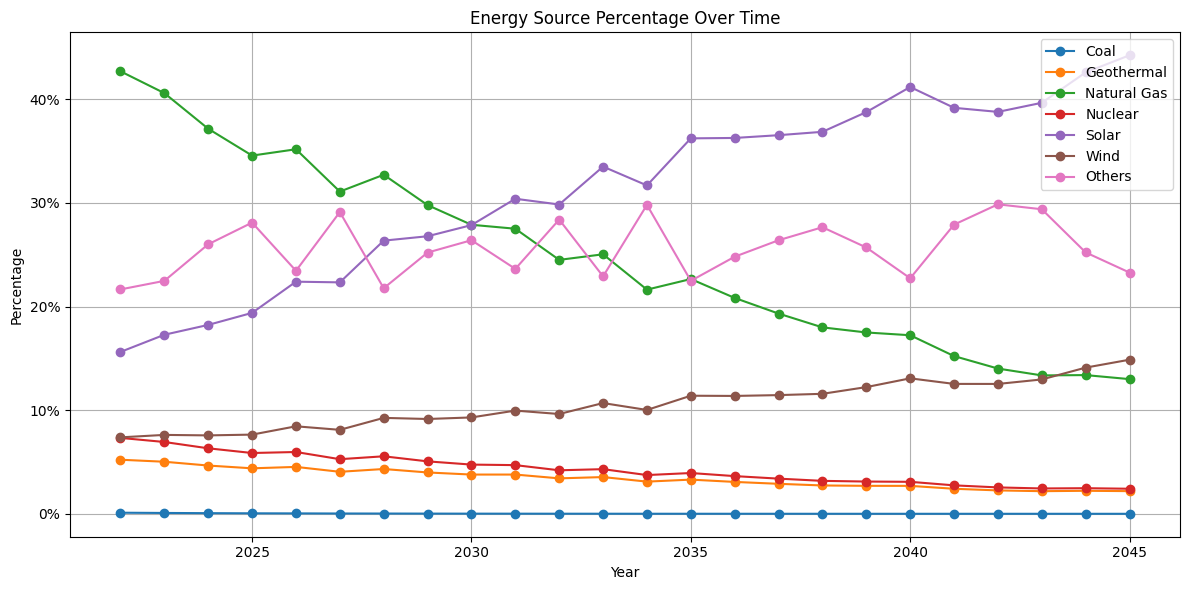

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Regression models for estimating energy source percentages over time ---

def percentage_coal(t):
    # Exponential decay model for coal usage over time
    return 0.0177 * np.e**(-0.2101 * (t - 2009))

def percentage_geothermal(t):
    # Logarithmic decay model for geothermal energy
    return -0.0029 * np.log(t - 2009) + 0.065

def percentage_natural_gas(t):
    # Exponential decay model for natural gas usage
    return 0.5814 * np.e**(-0.0162 * (t - 2009))

def percentage_nuclear(t):
    # Power-law decay model for nuclear energy contribution
    return 0.1683 * (t - 2009)**-0.2861

def percentage_solar(t):
    # Power-law growth model for solar energy share
    return 0.0016 * (t - 2009)**1.8243

def percentage_wind(t):
    # Exponential growth model for wind energy share
    return 0.0345 * np.e**(0.066 * (t - 2009))

def percentage_others(total_percentage):
    # Computes remaining percentage to make the total equal to 100%
    return 1 - total_percentage

# --- Compute energy source thresholds for a given year ---
def calculate_thresholds(year):
    """
    Calculates the estimated share of each energy source for a given year.
    The values are normalized so that their total falls between 69% and 79%.
    """
    t = year
    coal = percentage_coal(t)
    geothermal = percentage_geothermal(t)
    natural_gas = percentage_natural_gas(t)
    nuclear = percentage_nuclear(t)
    solar = percentage_solar(t)
    wind = percentage_wind(t)

    # Set a realistic random total percentage to simulate supply capacity constraints
    random_percentage = np.random.uniform(0.69, 0.79)
    total = coal + geothermal + natural_gas + nuclear + solar + wind
    factor = random_percentage / total  # Normalization factor

    # Apply normalization to each source
    coal *= factor
    geothermal *= factor
    natural_gas *= factor
    nuclear *= factor
    solar *= factor
    wind *= factor

    # Compute remaining share for 'others'
    others = percentage_others(random_percentage)

    return coal, geothermal, natural_gas, nuclear, solar, wind, others

# --- Generate time-series data for all years from 2022 to 2045 ---

years = list(range(2022, 2046))  # Forecast period
coal_vals = []
geo_vals = []
gas_vals = []
nuclear_vals = []
solar_vals = []
wind_vals = []
others_vals = []

# Compute and store values for each year
for yr in years:
    coal_val, geo_val, gas_val, nuc_val, solar_val, wind_val, other_val = calculate_thresholds(yr)
    coal_vals.append(coal_val)
    geo_vals.append(geo_val)
    gas_vals.append(gas_val)
    nuclear_vals.append(nuc_val)
    solar_vals.append(solar_val)
    wind_vals.append(wind_val)
    others_vals.append(other_val)

# --- Plot the data as a line graph ---

plt.figure(figsize=(12, 6))
plt.plot(years, coal_vals, label='Coal', marker='o')
plt.plot(years, geo_vals, label='Geothermal', marker='o')
plt.plot(years, gas_vals, label='Natural Gas', marker='o')
plt.plot(years, nuclear_vals, label='Nuclear', marker='o')
plt.plot(years, solar_vals, label='Solar', marker='o')
plt.plot(years, wind_vals, label='Wind', marker='o')
plt.plot(years, others_vals, label='Others', marker='o')

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))  # '_' is intentionally unused

# Set plot metadata
plt.title('Energy Source Percentage Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and display plot
plt.savefig('standalone_energy_percentages.png')
plt.show()

## Comparison to Califronia Government Goals

Prediction:
| Year | Renewable (%) | Non-Renewable (%) |
|------|----------------|--------------------|
| 2035 | 76.93           |    23.07          |
| 2040 | 82.85           |    17.15          |
| 2045 | 87.55           |    12.45

Goal:
| Year | Renewable (%) | Non-Renewable (%) |
|------|----------------|--------------------|
| 2035 | 60             | 40                 |
| 2040 | 90             | 10                 |
| 2045 | 100            | 0

Our regression models shows that the 2035 goal can be met. However, there must be improvement to reach the 2045 goal.
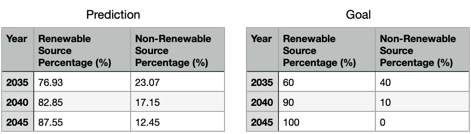